In [1]:
import sys
import os
import time
import datetime

import numpy as np
import pandas as pd

import shutil

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


import tensorflow as tf


from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



Using TensorFlow backend.


In [2]:
# Configure input/ output directory
# Configure training, validation, testing directory
#get the current working directory
cwd = os.getcwd()

input_directory = cwd+r"/chest_xray/"
output_directory = cwd+r"/chest_xray/"

training_dir = cwd+"/chest_xray/train/"
validation_dir = cwd+"/chest_xray/val/"
testing_dir = cwd+"/chest_xray/test/"

model_dir = cwd+r"/chest_xray/"
log_dir =cwd+r"/chest_xray/"
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

print(input_directory)
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

C:\Users\KV\Desktop/chest_xray/


In [3]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [4]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [5]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [6]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

In [7]:

def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(150, 150,3)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(150, 150,3)))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model

In [8]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    
    x = BatchNormalization()(x)
    predictions = Dense(2, activation='softmax')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False

    
    model.summary()
        
    return model

In [9]:
model = get_conv_model()
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)
optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100
model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)       

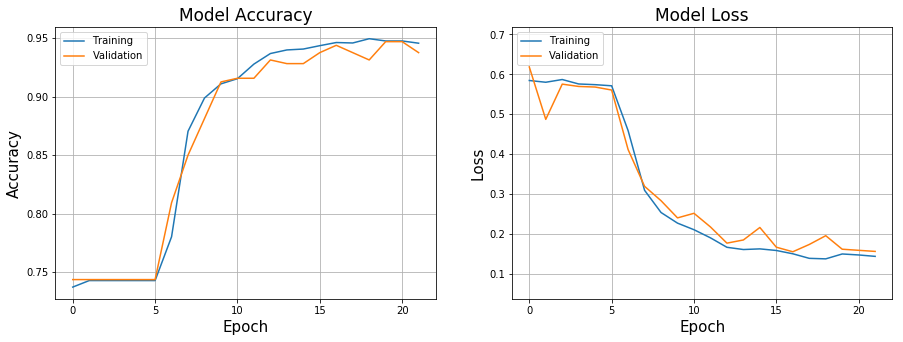

In [10]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [11]:
model_names = os.listdir(model_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

0 .DS_Store
1 01-val_acc-0.74-val_loss-0.62.hdf5
2 07-val_acc-0.81-val_loss-0.41.hdf5
3 08-val_acc-0.85-val_loss-0.32.hdf5
4 09-val_acc-0.88-val_loss-0.28.hdf5
5 10-val_acc-0.91-val_loss-0.24.hdf5
6 11-val_acc-0.92-val_loss-0.25.hdf5
7 13-val_acc-0.93-val_loss-0.18.hdf5
8 16-val_acc-0.94-val_loss-0.17.hdf5
9 17-val_acc-0.94-val_loss-0.16.hdf5
10 20-val_acc-0.95-val_loss-0.16.hdf5
11 events.out.tfevents.1569012756.DESKTOP-0Q7CA2P
12 events.out.tfevents.1569013037.DESKTOP-0Q7CA2P
13 generate_tfrecord.py
14 test
15 train
16 val


In [22]:
model_file = cwd+"/chest_xray/"+model_names[10]

print(model_file)

C:\Users\KV\Desktop/chest_xray/20-val_acc-0.95-val_loss-0.16.hdf5


In [23]:
model = keras.models.load_model(model_file)

In [24]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
1/1 [==============================] - 2s 2s/step
Loss     : 0.35  
Accuracy : 87.81%


In [25]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
1/1 [==============================] - 2s 2s/step


In [27]:
title = model_file.split("/")
model_title = "/".join([i for i in title[3:]])

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")


------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 83.43%
Recall        : 94.38%
F1-Score      : 88.56%
------------------------------------------------------------------------------------------





In [28]:
import random
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 320
-----------------------------------
Accuracy                : 87.81%
-----------------------------------


In [36]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"\\"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()
    
    
 

In [34]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs

image_file_name_batch = cwd+"/chest_xray/test/"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}

dpi=100

ncols = 4
nrows = 8

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

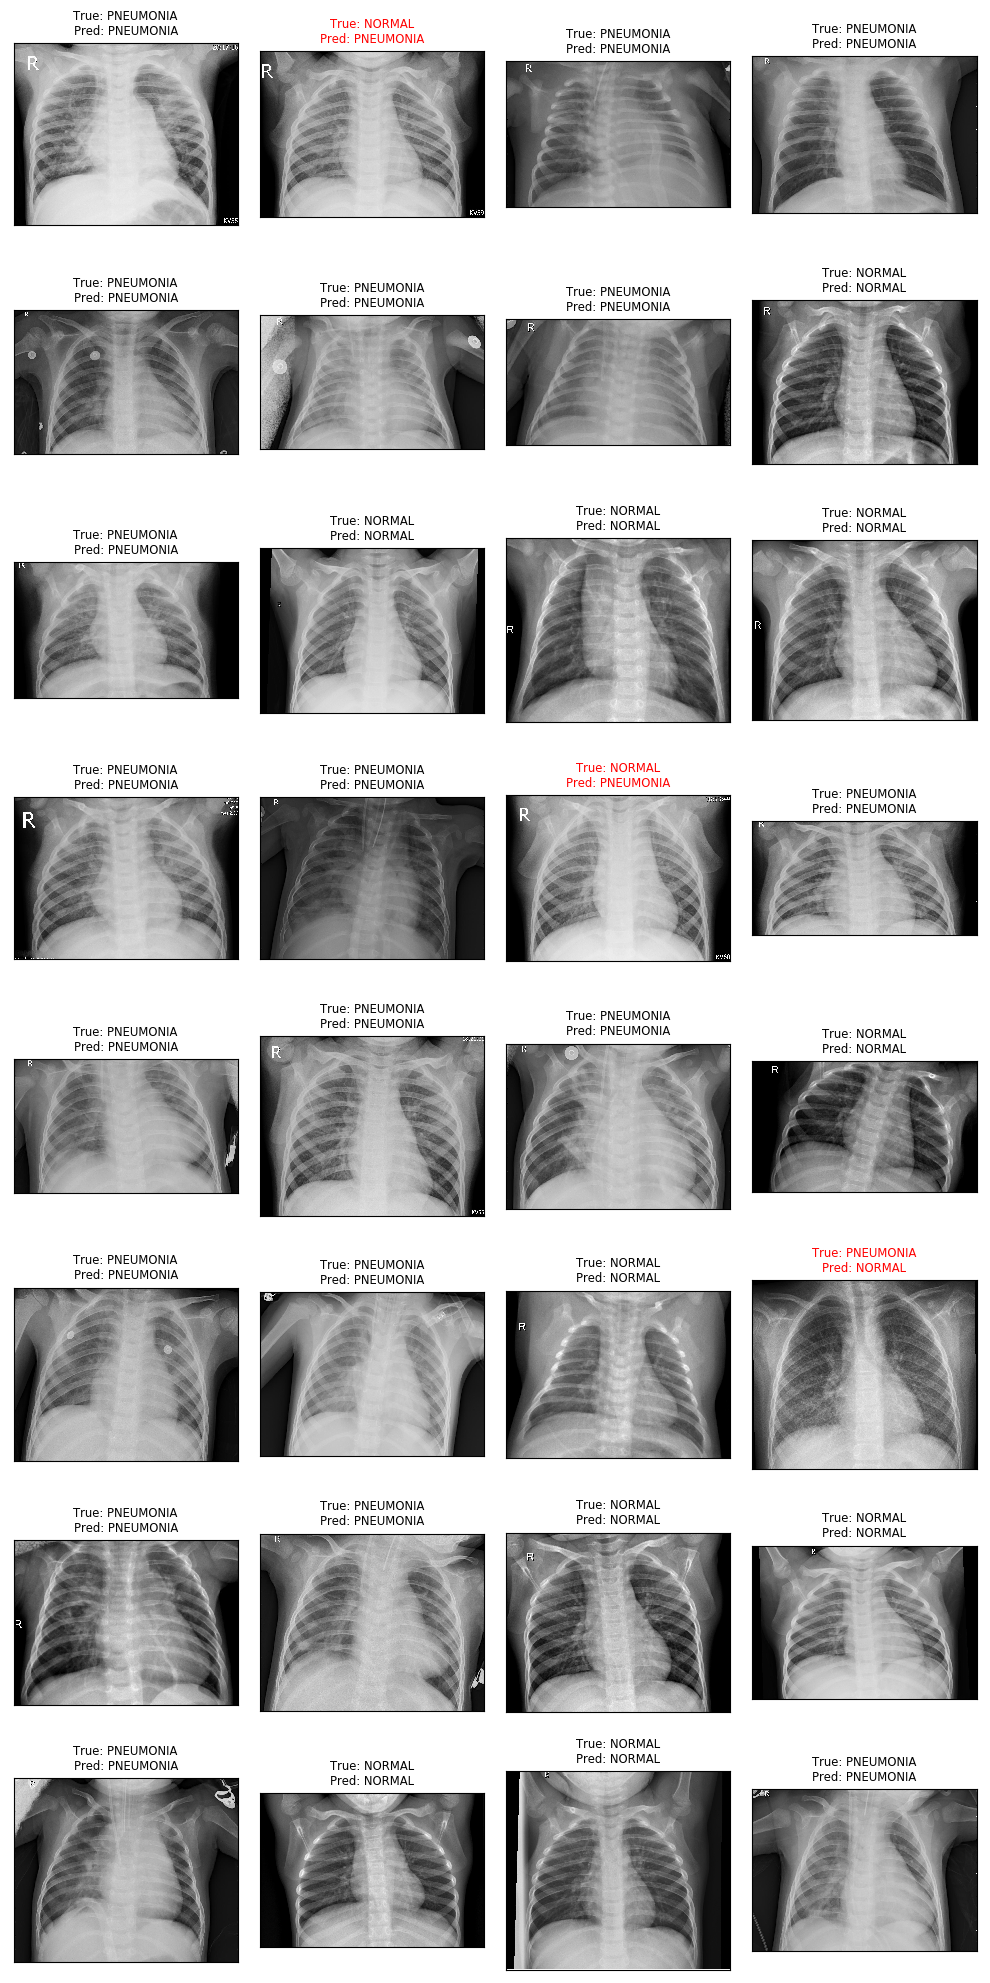

In [37]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)